Desenvolvido por Phillip Gallas

### Neste Notebook, eu escrevi uma rede neural capaz de identificar momentos de crise na economia brasileira

Os dados foram extraídos de IPEA, Banco Central do Brasil, Yahoo Finance e FecomercioSP. Os dados consistem de amostras mensais das variáveis referidas na célula abaixo, de janeiro de 1995 a janeiro de 2021.

In [1]:
# ---- BIBLIOTECAS --------------------------------------------------------------------
import numpy as np
import copy
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import statistics as stats
import seaborn as sns
import pandas as pd
import warnings




# ---- DADOS E PRÉ-PROCESSAMENTO ------------------------------------------------------
rawdata = pd.read_excel("./NewData.xlsx")
rawdata = np.array(rawdata[47:])[:,:17] # A partir de 1995.1, descondierando petróleo e outras 
#variáveis incabíveis


colname = ['PIB','SELIC','INFLAÇÃO','CÂMBIO','BOVESPA','ICC','INPC','SALÁRIO','BASE MONETÁRIA',
           'DIV INTER','DIV EXTER','PROD INDUSTRIAL','BALANÇA CORRENTE','BALANÇA COMERCIAL','DIV TOTAL'] 

rec_rows = np.array([0,1,2,3,4,5,6,7,8, # 1995 
                     34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50, # 1998-1999
                     75,76,77,78,79,80,81,82,83, # 2001.T2 - 2001.T4
                     93,94,95,96,97,98,99,100,101,102, # 2003.T1, 2003.T2
                     163,164,165,166,167,168,169, # 2008.T4, 2009.T1
                     231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,
                     260,261,262,263, # 2014-2016
                     300,301,302,303,304,305,306,307,308,309,310,311,312]) # 2020-presente(2021)



data = np.array(rawdata[:,2].reshape(313,1))
undesirable = ['INPC','SALÁRIO','BASE MONETÁRIA','DIV INTER','DIV EXTER','BALANÇA CORRENTE']  # Esta lista retira variáveis para teste

for n in range(1,len(colname)):
    if colname[n] in undesirable:
        continue
    data = np.append(data,rawdata[:,n+2].reshape(313,1),axis=1)

for u in undesirable:
    colname.remove(u)

    
    

# ---- Normalização ---------------------------------------------- 
norm = copy.deepcopy(data)
for n in range(norm.shape[1]):
    # Normalizando entre -1 e 1 
    norm[:,n] = (1-(-1))*np.divide((norm[:,n] - np.min(norm[:,n])),(np.max(norm[:,n]) - np.min(norm[:,n]))) -1 
    #norm[:,n] = np.divide((norm[:,n] - np.min(norm[:,n])),(np.max(norm[:,n]) - np.min(norm[:,n])))
    
    
    
    
# ---- Labels -----------------------------------------------------
# 1 Output - 0 (não crise), 1 (crise)
label = np.array([[0,0]]) # Dados da saída da classificação
for n in range(len(norm[:,0])):
    if n in rec_rows: # Checando pela posição no array Rec_Rows
        label = np.append(label,[[1,0]],axis=0)
    else:
        label = np.append(label,[[0,1]],axis=0)
else:
    label = label[1:,:]
#     # Crise: [1,0]; Não-crise: [0,1]

    


    
# ---- Entrada e saída da MLP de Classificação ---------------------
in_ = norm[:,:] # Entradas Reais da classificação
out_ = label[:,:] # Saída Real da classificação





# ---- Segregando entre treino e teste -----------------------------
# 70% Treino, 30% Teste
train_set = round(0.7*in_.shape[0]) # Número de elementos usados para treino
indexes = np.arange(in_.shape[0]) # Array de índices a serem randomizado e segregados





# Plotando Scatter Plot
if False: # True plota, False não plota:
    plotting_data = in_[:,:]
    fig,axs = plt.subplots(plotting_data.shape[1],plotting_data.shape[1])
    fig.set_figheight(17)
    fig.set_figwidth(17)

    for row,row_data in zip(range(plotting_data.shape[1]),np.arange(plotting_data.shape[1])):
        for col,col_data in zip(range(plotting_data.shape[1]),np.arange(plotting_data.shape[1])):

            if (row!=col):
                axs[row,col].scatter(plotting_data[:,col_data],plotting_data[:,row_data])

            if (row==col):
                axs[row,col].text(0.5,0.5,colname[col],horizontalalignment="center",verticalalignment="center")

            if (row<col):
                axs[row,col].set_visible(False)

            axs[row,col].set_xticklabels([])
            axs[row,col].set_yticklabels([])

    print("Scatter Plot dos dados normalizados")
    plt.show()
    
    


# Printando a razão de dados de crise
if True: # True print, False não print
    print("Razão de dados de crise para de não-crise (total):",np.count_nonzero(out_[:,0] == 1)/out_.shape[0])
    
print(colname)

Razão de dados de crise para de não-crise (total): 0.31309904153354634
['PIB', 'SELIC', 'INFLAÇÃO', 'CÂMBIO', 'BOVESPA', 'ICC', 'PROD INDUSTRIAL', 'BALANÇA COMERCIAL', 'DIV TOTAL']


In [ ]:
# Caso se queira retirar o PIB da análise, rodar esta célula
colname = colname[1:]; norm = norm[:,1:]
print(colname)

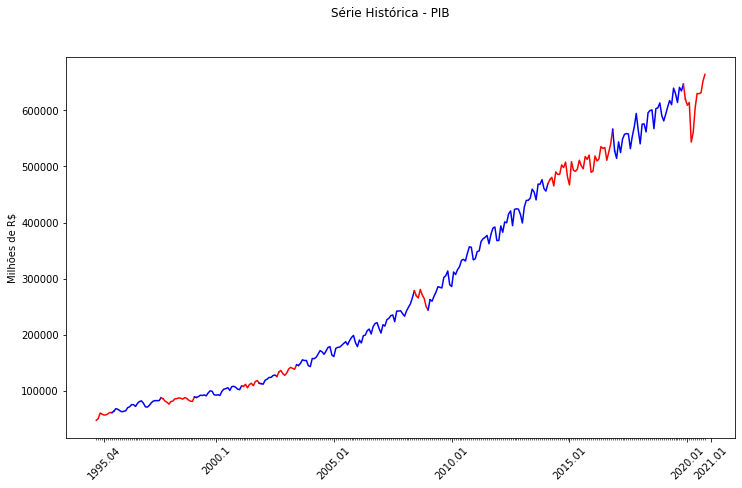

In [2]:
newcolors = ['red' if x in rec_rows else 'blue' for x in np.arange(0,len(norm[:,0]))]
fig,ax = plt.subplots()
row = 0; N = 0

var = 0 # var é a chave de escolha de qual variável plotar

while(True):
    try:
        if (newcolors[row+N] == newcolors[row+N+1]):
            N += 1
        else:
            # plotar consecutivos
            ax.plot(np.arange(row,row+N+1),data[row:row+N+1,var],newcolors[row])
            row += N

            # plotar diferentes
            ax.plot([row,row+1],data[row:row+2,var],newcolors[row+1])
            row += 1
            N = 0

    except IndexError:
        ax.plot(np.arange(row,row+N-1),data[row:row+N-1,var],newcolors[row])
        break

plt.xticks(np.array([50,107,167,227,287,347,359])-46,["1995.04","2000.1","2005.01","2010.01",
                                         "2015.01","2020.01","2021.01"])

ax.set_xticks(np.arange(0,data[0:-2,0].shape[0]),minor=True)
plt.ylabel("Milhões de R$")
fig.suptitle(f"Série Histórica - {colname[var]}")
fig.set_figheight(7)
fig.set_figwidth(12)
ax.tick_params (axis='x', labelrotation= 45) # ax's específicas
plt.show()

# Referência
# https://portalibre.fgv.br/sites/default/files/2020-06/comunicado-do-comite-de-datacao-de-ciclos-economicos-29_06_2020-1.pdf

In [3]:
# ---- Funções de ativação
def sigmoid(x,a=1):
    return 1/(1 + np.exp(-a*x))

def dsigmoid(x,a=1):
    return sigmoid(x,a)*(1 - sigmoid(x,a))

def tanh(x,a=1):
    return np.tanh(a*x)

def dtanh(x,a=1):
    return (1/a)*((a**2)-(np.tanh(a*x)**2))



# ---- Classe: Layer
class Layer:
    def __init__(self,Neurons,l,function):
        self.function = function
        if l != 0:
            if self.function in ['tanh','leaky relu']:
                self.W = np.random.uniform(-1,1,size=(Neurons,len(rede[l-1].Y)))
            if self.function == 'sigmoid':
                self.W = np.random.uniform(0,1,size=(Neurons,len(rede[l-1].Y)))
            
        else:
            if self.function in ['tanh','leaky relu']:
                self.W = np.random.uniform(-1,1,size=(Neurons,in_.shape[1]))
            if self.function == 'sigmoid':
                self.W = np.random.uniform(0,1,size=(Neurons,in_.shape[1]))
        
        self.B = np.random.uniform(-1,1,size=(Neurons))
        self.Sum = np.ones((Neurons))
        self.Y = np.ones((Neurons))
        self.Delta = np.ones((Neurons))
        
        

    def activation(self,data,a): # Poderia fazer 'closure', mas acho que assim fica mais fácil:
        if self.function == 'sigmoid':
            return sigmoid(data,a)
        if self.function == 'tanh':
            return tanh(data,a)
        if self.function == 'leaky relu':
            return leaky_relu(data,a)
    
    def derivative(self,data,a):
        if self.function == 'sigmoid':
            return dsigmoid(data,a)
        if self.function == 'tanh':
            return dtanh(data,a)
        if self.function == 'leaky relu':
            return dleaky_relu(data,a)

In [4]:
# Janelas de tempo
# A pesquisa tentou ser o mais rápido possível. Então, embora resultados muito bons com PIB e 6 ou 9 meses, prefeririu-se testes de 
# 2 a 6 meses sem PIB e sem sknewness e sem curtosis

window_size = 6 # Janelas de 6 meses
number_windows = norm.shape[0] + 1 - window_size

window_in = {}
window_out = np.array([[0,0]])

for n in range(number_windows): # Agrupar input e output em janelinhas
    window_in[n] = norm[n:n+window_size,:] # Original
    
    if any( [elem in rec_rows for elem in np.arange(n,n+window_size)] ):
        # Se ao menos um dos meses dentro da 'janela' estiver classificado pela CODACE como crise
        # a janela inteira será classificada como crise
        window_out = np.append(window_out,[[1,0]],axis=0)
    else:
        window_out = np.append(window_out,[[0,1]],axis=0)
else:
    out_ = window_out[1:] # Crise: [1,0], Não-Crise: [0,1]



# Desses input em janelinha eu devo extrair características:
C = ['mean',     # 0. média
     'std',      # 1. desvio padrão/variância
#      'kurtosis', # 2. curtose 
#      'skewness', # 3. obliquidade
     'diff' # 4. diferenciação de mês a mês dentro da janela e somando. Cada diferenciação pode ser multiplicada por um fator
    ] 

in_ = np.zeros(shape=(number_windows,len(colname)*len(C)))
# C também refere-se ao número de características extraídas


for window_group in range(number_windows):
    col = 0
    if 'mean' in C:
        in_[window_group,col:col+(len(colname))] = np.mean(window_in[window_group][:,:],axis=0)
        col += len(colname)

    if 'std' in C:
        in_[window_group,col:col+(len(colname))] = np.std(window_in[window_group][:,:],axis=0)
        col += len(colname)

    if 'cv' in C:
        in_[window_group,col:col+(len(colname))] = (np.std(window_in[window_group][:,:],axis=0)/
                                                  np.mean(window_in[window_group][:,:],axis=0))
        col += len(colname)

    if 'kurtosis' in C:
        in_[window_group,col:col+(len(colname))] = kurtosis(window_in[window_group][:,:])
        col += len(colname)

    if 'skewness' in C:
        in_[window_group,col:col+(len(colname))] = skew(window_in[window_group][:,:])
        col += len(colname)
        
    if 'diff' in C:
        diff = np.diff(window_in[window_group][:],axis=0)
        factors = np.linspace(start=0.2,stop=1,num=window_in[0].shape[0]-1).reshape(1,window_size-1)
        in_[window_group,col:col+(len(colname))] = np.dot(factors,diff)[0]
        col += len(colname)
        # Fatores podem ser devido a 2 coisas: magnitude e o quão próximo é do mês mais recente
        # Mas esta implementação fica para próxima versão
        
        
if True:
    print("Razão de dados de crise para de não-crise (total):",np.count_nonzero(out_[:,0] == 1)/out_.shape[0])

Razão de dados de crise para de não-crise (total): 0.39935064935064934


In [5]:
# ---- Criação da Rede Neural: Inputs-L-2 --------------------------------------------
N = 60 
L = 3
No = 2 # Número de neurônios de saída; lembrando: [0,1] = não crise, [1,0] = crise

rede = {}
for l in range(L):
    rede[l] = Layer(N,l,'tanh')
else:
    rede[L] = Layer(No,L,'sigmoid') # Camada de saída
print("Rede Neural ",in_.shape[1],"-",L,"(",N,")-",No," criada",sep="")





# ---- VARIÁVEIS ----------------------------------------------------------------------
EPOCHS = 60 # 60 # inicialmente. Checar com o número de épocas
ROUNDS = 10 # 10 parece ser o sweetspot para 6 entradas 
rate = 0.2 # Posso experimentar com rate variável. Maior para início do treinamento, menor para refino
alpha = 0.5 # Para momentum
a = 1
score_rate = np.array([]) # Taxa de acerto
Lce_progression = {}





# ---- Segregando entre treino e teste ------------------------------------------------
# 70% Treino, 30% Teste
# 85% Treino, 15% Teste
train_set = round(0.70*in_.shape[0]) # Número de elementos usados para treino
indexes = np.arange(in_.shape[0]) # Array de índices a serem randomizado e segregados

# Randomizando quais são os dados de teste e treino em rada rodada, 
# para aumentar a robustez da Rede Neural
np.random.shuffle(indexes)

# Fazer algoritmo que garanta que todo treino será feito ao menos 45% dados de Crise
# Testes são dados originais para a rede neural, não vistos durante o treino
i_train = in_[indexes[0:train_set],:]
o_train = out_[indexes[0:train_set]]
i_test = in_[indexes[train_set:],:]
o_test = out_[indexes[train_set:]]

while(np.count_nonzero(o_train[:,0]==1)/o_train.shape[0] < 0.43): # ao menos 43% de dados de recessão
    np.random.shuffle(indexes)
    i_train = in_[indexes[0:train_set],:]
    o_train = out_[indexes[0:train_set]]
    i_test = in_[indexes[train_set:],:]
    o_test = out_[indexes[train_set:]]

print("Proporção Recessão/Total = ",(np.count_nonzero(o_train[:,0]==1)/o_train.shape[0]))


# ---- Teste: Revert Back 
# RevertBack é um meio de guardar o(s) melhore(s) estado(s) da Rede Neural, em que sua acurácia foi maior
RevertBackScore = 0
print(" ************************************************ ")



# ---- Rede Neural & Aprendizagem -------------------------------------------------
for rounds in range(ROUNDS):
    print("Round:",rounds)
    Lce_carrier = np.array([])
    
    for counter in range(EPOCHS):
        order = np.arange(i_train.shape[0])
        np.random.shuffle(order) # Randomizando o set de treinamento
        error = np.zeros(shape=(o_train.shape[0],2))
        Lce = np.array([])
        for each in order:
            l = 0
            # ---- Forward pass
            rede[0].Sum = np.dot(rede[0].W,i_train[each,:]) + rede[0].B
            rede[0].Y = rede[0].activation(rede[0].Sum,a)
            
            for l in range(1,L+1): # Da camada 1 a L
                rede[l].Sum = np.dot(rede[l].W,rede[l-1].Y) + rede[l].B
                rede[l].Y = rede[l].activation(rede[l].Sum,a)
            
            # ---- Retropropagação -- online learning
            error[each] = o_train[each,:] - rede[l].Y
#             testy = rede[l].Y
#             testo = o_train[each,:]
            
            Lce = np.append(Lce,[-np.dot(np.log2(rede[l].Y + 1e-8),o_train[each,:])],axis=0)
            lim = 0.1
            if all(Lce[-5:] < lim) and (rounds > 0): 
                if score_rate[-1] > 0.9: # teste
                    break
                else: 
                    continue
            
            # originally, only if with 'lim' without the 'if all' above
            
            if Lce[-1] < 0.15: # Adicionar um comando para parar o treino?
                rate = 0.1 
            else:
                rate = 0.2 
            
            l = L
            for n in range(len(rede[L].Y)): # Para cada neuronio de SAÍDA
                rede[l].Delta[n] = error[each,n]*rede[l].derivative(rede[l].Sum[n],a)
                rede[l].W[n] += rate*rede[l].Delta[n]*rede[l].Y[n]
                rede[l].B[n] += rate*rede[l].Delta[n]
            
            
            for l in reversed(range(0,L)): # de l-1 a 0, same as range(l-1,-1,-1)
                for n in range(len(rede[l].Y)):
                    summation = np.dot(rede[l+1].Delta,rede[l+1].W[:,n])
                    rede[l].Delta[n] = rede[l].derivative(rede[l].Sum[n],a)*summation
                    
                    if l != 0:
                        rede[l].W[n] += rate*rede[l].Delta[n]*rede[l-1].Y
                    else:
                        rede[l].W[n] += rate*rede[l].Delta[n]*i_train[each,:]
                        
                    rede[l].B[n] += rate*rede[l].Delta[n]
            
        
        
        
            # ---- Testando cada época
            Score = 0
            Order = np.arange(i_test.shape[0])
            for sample in Order:
                # ---- Forward pass
                rede[0].Sum = np.dot(rede[0].W,i_test[sample,:]) + rede[0].B 
                rede[0].Y = rede[0].activation(rede[0].Sum,a)

                for l in range(1,L+1):
                    rede[l].Sum = np.dot(rede[l].W,rede[l-1].Y) + rede[l].B
                    rede[l].Y = rede[l].activation(rede[l].Sum,a)


                # Checando se os índices esperados batem com os índices previstos. 
                # Tática de verificar se o sistema acertou ou não
                index_max_expected = np.argmax(rede[l].Y) # Retorna o índice do maior elemento esperado
                index_max_yielded = np.argmax(o_test[sample,:]) # Retorna o índice do maior elemento previsto

                if (index_max_expected == index_max_yielded):
                    Score += 1

            if (Score/(i_test.shape[0]) > RevertBackScore):
                RevertBackState = copy.deepcopy(rede)
                RevertBackScore = Score/(i_test.shape[0])
                print("\tState stored",RevertBackScore)
        
        
        
        Lce_carrier = np.append(Lce_carrier,[np.mean(Lce)],axis=0)
                
        # ---- Testando cada época
        score = 0
#         Y_record = np.zeros(shape=(i_test.shape[0],2))
        order = np.arange(i_test.shape[0])
        for sample in order:
            # ---- Forward pass
            rede[0].Sum = np.dot(rede[0].W,i_test[sample,:]) + rede[0].B 
            rede[0].Y = rede[0].activation(rede[0].Sum,a)
            
            for l in range(1,L+1):
                rede[l].Sum = np.dot(rede[l].W,rede[l-1].Y) + rede[l].B
                rede[l].Y = rede[l].activation(rede[l].Sum,a)

            
#             Y_record[sample] = rede[l].Y
                
            # Checando se os índices esperados batem com os índices previstos. 
            # Tática de verificar se o sistema acertou ou não
            index_max_expected = np.argmax(rede[l].Y) # Retorna o índice do maior elemento esperado
            index_max_yielded = np.argmax(o_test[sample,:]) # Retorna o índice do maior elemento previsto
            
            if (index_max_expected == index_max_yielded):
                score += 1

    score_rate = np.append(score_rate,[score/(i_test.shape[0])],axis=0)
    Lce_progression[rounds] = Lce_carrier
    print("*** complete, with score_rate of",score_rate[-1])

# ---- Computando e mostrando os resultados
score_mean = stats.mean(score_rate)
score_variance = stats.variance(score_rate)

print(f"Taxa de acerto média:       {score_mean}")
print(f"Variância da taxa de acerto: {score_variance}\n\n")

Rede Neural 27-3(60)-2 criada
Proporção Recessão/Total =  0.4305555555555556
 ************************************************ 
Round: 0
	State stored 0.358695652173913
	State stored 0.3695652173913043
	State stored 0.3804347826086957
	State stored 0.40217391304347827
	State stored 0.42391304347826086
	State stored 0.45652173913043476
	State stored 0.4673913043478261
	State stored 0.5217391304347826
	State stored 0.5543478260869565
	State stored 0.5652173913043478
	State stored 0.5869565217391305
	State stored 0.6521739130434783
	State stored 0.6739130434782609
	State stored 0.7608695652173914
	State stored 0.7717391304347826
	State stored 0.8152173913043478
	State stored 0.8260869565217391
	State stored 0.8369565217391305
	State stored 0.8478260869565217
	State stored 0.8586956521739131
	State stored 0.8695652173913043
	State stored 0.8913043478260869
	State stored 0.9021739130434783
	State stored 0.9239130434782609
	State stored 0.9347826086956522
	State stored 0.9565217391304348
***

In [7]:
# Print predições da Rede Neural

# Print das predições de teste
for sample in range(i_test.shape[0]):
    rede[0].Sum = np.dot(rede[0].W,i_test[sample,:]) + rede[0].B 
    rede[0].Y = rede[0].activation(rede[0].Sum,a)

    for l in range(1,L+1):
        rede[l].Sum = np.dot(rede[l].W,rede[l-1].Y) + rede[l].B
        rede[l].Y = rede[l].activation(rede[l].Sum,a)
    
    print(rede[l].Y,"\t",o_test[sample])


# Resultado das predições de todos os dados
score = 0
Order = np.arange(in_.shape[0])
for sample in Order:
    rede[0].Sum = np.dot(rede[0].W,in_[sample,:]) + rede[0].B 
    rede[0].Y = rede[0].activation(rede[0].Sum,a)

    for l in range(1,L+1):
        rede[l].Sum = np.dot(rede[l].W,rede[l-1].Y) + rede[l].B
        rede[l].Y = rede[l].activation(rede[l].Sum,a)

    index_max_expected = np.argmax(rede[l].Y) 
    index_max_yielded = np.argmax(out_[sample,:]) 

    if (index_max_expected == index_max_yielded):
        score += 1

Score = score/(in_.shape[0])
print("Taxa de acerto (todos os dados):",Score)


[0.97996563 0.22984866] 	 [1 0]
[0.01873824 0.9817457 ] 	 [0 1]
[0.04917157 0.99358469] 	 [0 1]
[0.96315087 0.07303328] 	 [1 0]
[0.92233807 0.05120764] 	 [1 0]
[0.04089705 0.99279575] 	 [0 1]
[0.99944332 0.29489328] 	 [1 0]
[0.99815814 0.99997087] 	 [0 1]
[0.10583449 0.99631952] 	 [0 1]
[0.98008698 0.01053373] 	 [1 0]
[0.11751407 0.94395591] 	 [0 1]
[0.00803144 0.96771383] 	 [0 1]
[0.08065642 0.99717229] 	 [0 1]
[0.99645895 0.99999102] 	 [0 1]
[0.02830761 0.98772771] 	 [0 1]
[0.95416022 0.00246687] 	 [1 0]
[0.99825475 0.99403337] 	 [1 0]
[0.02137811 0.98487563] 	 [0 1]
[0.99871012 0.1111906 ] 	 [1 0]
[0.91338889 0.00288042] 	 [1 0]
[0.99390466 0.17914072] 	 [1 0]
[0.97493709 0.08603029] 	 [1 0]
[0.27371988 0.99922445] 	 [0 1]
[2.28919247e-01 1.67558803e-04] 	 [1 0]
[0.9934191  0.99998969] 	 [0 1]
[0.96541146 0.04055781] 	 [1 0]
[0.01276846 0.97883038] 	 [0 1]
[0.07293534 0.99290818] 	 [0 1]
[0.18763176 0.66983381] 	 [0 1]
[0.015498   0.98188901] 	 [0 1]
[0.00771572 0.97736757] 	 [0 1]


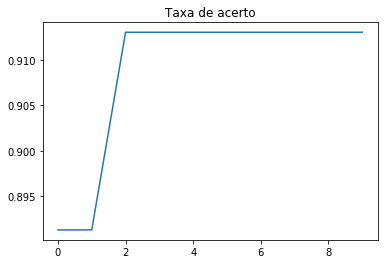

In [9]:
fig, ax = plt.subplots()
ax.plot(score_rate)
ax.set_title("Taxa de acerto ao longo dos rounds")
plt.show()

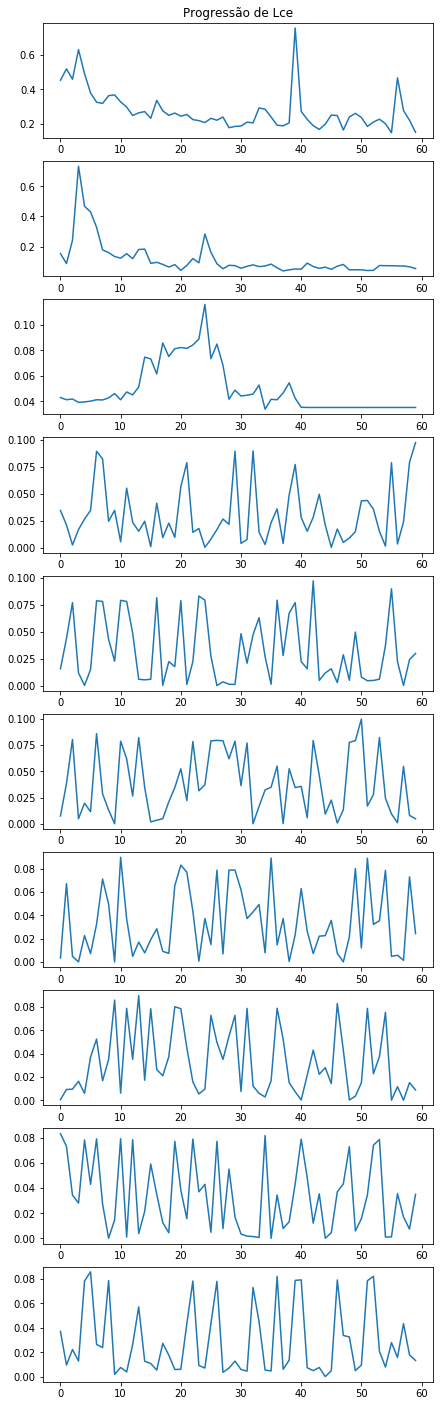

In [10]:
fig, ax = plt.subplots(ROUNDS)
fig.set_figwidth(7)
fig.set_figheight(25)
ax[0].set_title("Progressão de Lce")
for rounds in range(ROUNDS):
    ax[rounds].plot(Lce_progression[rounds])
plt.show()